### Laboratorium 6 - część badawcza

W pakiecie OpenCV wszystkie zadania związane z detekcją i opisem punktów kluczowych realizowane są przez zestaw specjalnych klas, dla których bazową jest `cv::Feature2D`. Jedną z wielu pochodnych tej klasy jest interesująca nas na zajęciach `cv::SIFT`, z której dokumentacją należy się zapoznać.  
Najważniejsze, co trzeba wiedzieć:
1. do konstrukcji obiektu SIFT służy metoda [`cv2.SIFT_create`](https://docs.opencv.org/4.x/d7/d60/classcv_1_1SIFT.html#ad337517bfdc068ae0ba0924ff1661131) - to do niej przekazujemy parametry detektora (w dokumentacji występuje jako `cv::SIFT::create`);
2. obsługujemy detektor przez interfejs `cv::Feature2D`, konkretnie metody [`detect`](https://docs.opencv.org/4.x/d0/d13/classcv_1_1Feature2D.html#aa4e9a7082ec61ebc108806704fbd7887) do detekcji punktów kluczowych oraz [`compute`](https://docs.opencv.org/4.x/d0/d13/classcv_1_1Feature2D.html#ab3cce8d56f4fc5e1d530b5931e1e8dc0) do obliczania ich deskryptorów (opcjonalnie `detectAndCompute`).

Schemat użycia:
```python
sift_instance = cv2.SIFT_create()
# 'image' powinno być obrazem jednokanałowym (jeśli nie, zostanie zastosowane cvtColor z flagą COLOR_BGR2GRAY)
keypoints = sift_instance.detect(image)
keypoints, descriptors = sift_instance.compute(image, keypoints)
```

`keypoints` jest listą obiektów specjalnego typu `cv2.KeyPoint`, która **jest modyfikowana** przez `SIFT::compute`!  
`descriptors` jest natomiast macierzą float32 o wymiarach NxK, gdzie N jest liczbą punktów kluczowych, a K jest liczbą obliczonych cech.

Warto również zapoznać się z funkcją [`cv2.drawKeypoints`](https://docs.opencv.org/4.x/d4/d5d/group__features2d__draw.html#ga5d2bafe8c1c45289bc3403a40fb88920) w kontekście prezentacji wyników. Zwróć uwagę na flagi sterujące rysowaniem - szczególnie użyteczna jest `cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS`.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

#### Zadanie 1

Przetestuj wpływ podstawowych parametrów detektora SIFT (`contrastThreshold` i `edgeThreshold`) na uzyskiwane punkty kluczowe (liczność, lokalizacja, rozmiar), korzystając z obrazów `cells` i `lena`. Pamiętaj że ich działanie jest odwrotne (tzn. jeden odsiewa cechy "mniejsze niż", a drugi "większe niż").

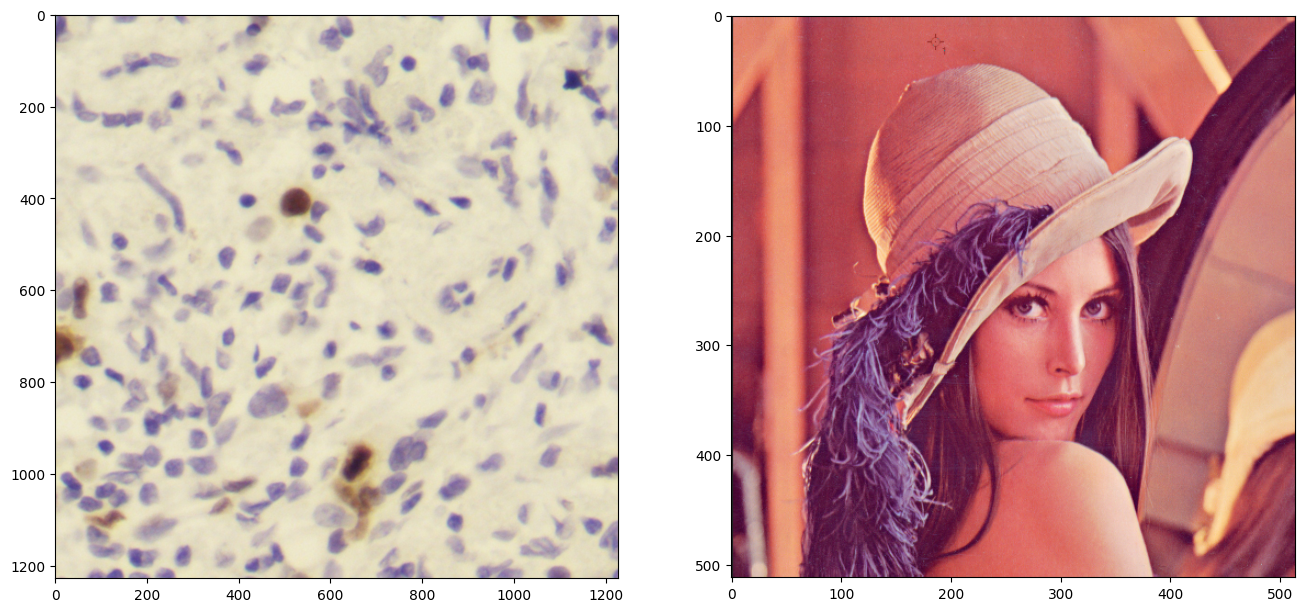

In [2]:
cells = cv2.imread('p1_0308_7.jpg')[..., ::-1]
lena = cv2.imread('Lena.jpg')[..., ::-1]
f, (a1, a2) = plt.subplots(1, 2, figsize=(16, 10))
a1.imshow(cells);
a2.imshow(lena);

In [3]:
from ipywidgets import interact, FloatSlider, fixed, Layout, IntSlider


def display_sift(img, ct, et):
    sift = cv2.SIFT_create(nfeatures = 0, contrastThreshold = ct, edgeThreshold = et)
    kp, ds = sift.detectAndCompute(img, mask = None)
    d_img = cv2.drawKeypoints(img, kp, None, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    _, axs = plt.subplots(1, 2, figsize = (10, 6))
    axs[0].imshow(img);
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    axs[1].imshow(d_img, cmap = 'gray');
    axs[1].set_title('(SIFT {} points)'.format(len(kp)))
    axs[1].axis('off')
    plt.show()


def interactive_sift(img):
    slider_layout = Layout(width = '70%')
    ct_slider = FloatSlider(value = 0.04, min = 0, max = 1, step = 0.01, description = "contrastThreshold", layout = slider_layout)
    et_slider = FloatSlider(value = 10, min = 0, max = 50, step = 0.1, description = "edgeThreshold", layout = slider_layout)

    interact(display_sift, img = fixed(img), ct = ct_slider, et = et_slider)

In [4]:
interactive_sift(lena)

interactive(children=(FloatSlider(value=0.04, description='contrastThreshold', layout=Layout(width='70%'), max…

In [5]:
interactive_sift(cells)

interactive(children=(FloatSlider(value=0.04, description='contrastThreshold', layout=Layout(width='70%'), max…

#### Zadanie 2

Detektor SIFT jest w teorii niezmienniczy względem translacji, rotacji czy zmiany skali. Przetestuj te własności w praktyce, sprawdzając stabilność punktów wykrywanych na obróconej i przeskalowanej wersji obrazów `cells` i `lena`. Dokonaj oceny wizualnie, sprawdzając zachowanie detektora dla kilku wybranych rotacji i skal (**nie** grid search).

_Co świadczy o stabilności i niezmienniczości detektora?_

In [6]:
def rotate(image, angle, scale=1.0):
    center = (image.shape[0] // 2, image.shape[1] // 2)
    rmat = cv2.getRotationMatrix2D(center, angle, scale)
    return cv2.warpAffine(image, rmat, (image.shape[0], image.shape[1]), flags=cv2.INTER_CUBIC)

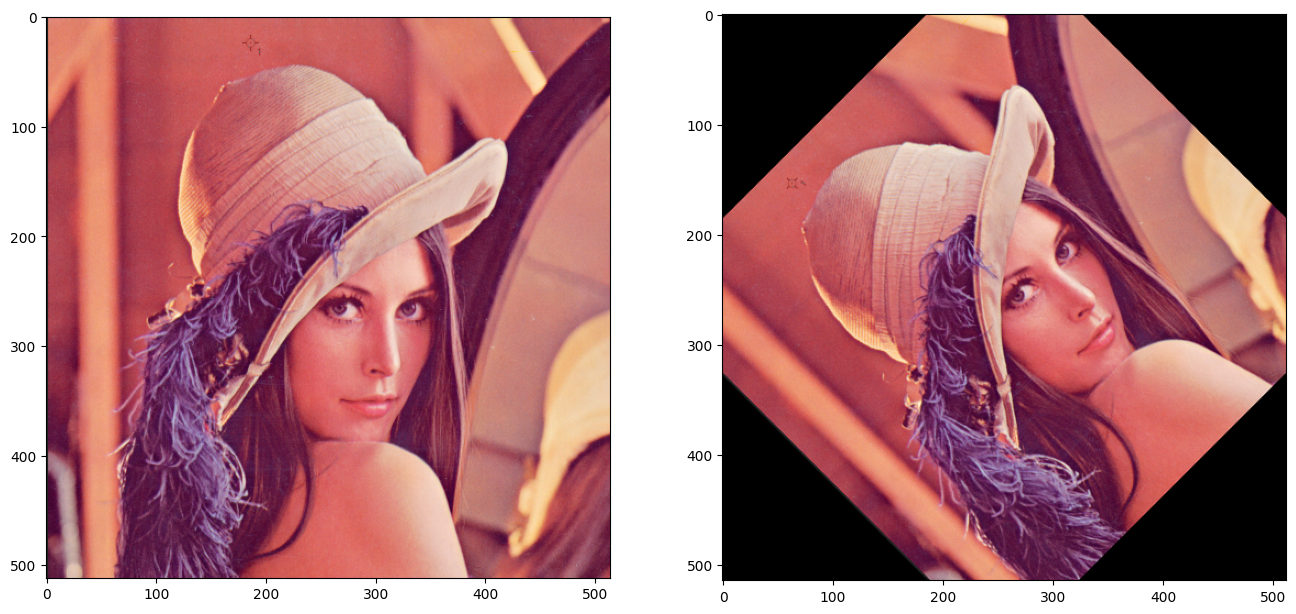

In [7]:
# przykład dla Leny, pamiętaj o cells!
lena_rot = rotate(lena, 45.0, scale=0.9)
f, (a1, a2) = plt.subplots(1, 2, figsize=(16, 10))
a1.imshow(lena);
a2.imshow(lena_rot);

In [8]:
def display_affine_sift(img, ct, et, angle, scale):
    img_affine = rotate(img, angle = angle, scale = scale)
    
    sift = cv2.SIFT_create(nfeatures = 0, contrastThreshold = ct, edgeThreshold = et)
    kp, ds = sift.detectAndCompute(img, mask = None)
    kp_affine, ds_affine = sift.detectAndCompute(img_affine, mask = None)
    d_img = cv2.drawKeypoints(img, kp, None, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    d_img_affine = cv2.drawKeypoints(img_affine, kp_affine, None, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    _, axs = plt.subplots(1, 2, figsize = (16, 10))
    axs[0].imshow(d_img);
    axs[0].set_title('SIFT ({} points)'.format(len(kp)))
    axs[0].axis('off')
    axs[1].imshow(d_img_affine);
    axs[1].set_title('Affine SIFT ({} points)'.format(len(kp)))
    axs[1].axis('off')
    plt.show()
    
    
def interactive_affine_sift(img):
    slider_layout = Layout(width = '40%')
    ct_slider = FloatSlider(value = 0.04, min = 0, max = 1, step = 0.01, description = "contrastThreshold", layout = slider_layout)
    et_slider = FloatSlider(value = 10, min = 0, max = 50, step = 0.1, description = "edgeThreshold", layout = slider_layout)
    angle_slider = IntSlider(value = 45, min = 0, max = 359, step = 1, description = "angle", layout = slider_layout)
    scale_slider = FloatSlider(value = 0.9, min = 0, max = 2, step = 0.1, description = "scale", layout = slider_layout)

    interact(display_affine_sift, img = fixed(img), ct = ct_slider, et = et_slider, angle = angle_slider, scale = scale_slider)

In [9]:
interactive_affine_sift(lena)

interactive(children=(FloatSlider(value=0.04, description='contrastThreshold', layout=Layout(width='40%'), max…

In [10]:
interactive_affine_sift(cells)

interactive(children=(FloatSlider(value=0.04, description='contrastThreshold', layout=Layout(width='40%'), max…

#### Zadanie 3

Dane są obrazy `coke` i `table`. Wykorzystaj metodologię parowania punktów kluczowych do znalezienia wystąpienia puszki z Colą na stole. To zadanie jest podzielone na dwie części - czytaj dalej.

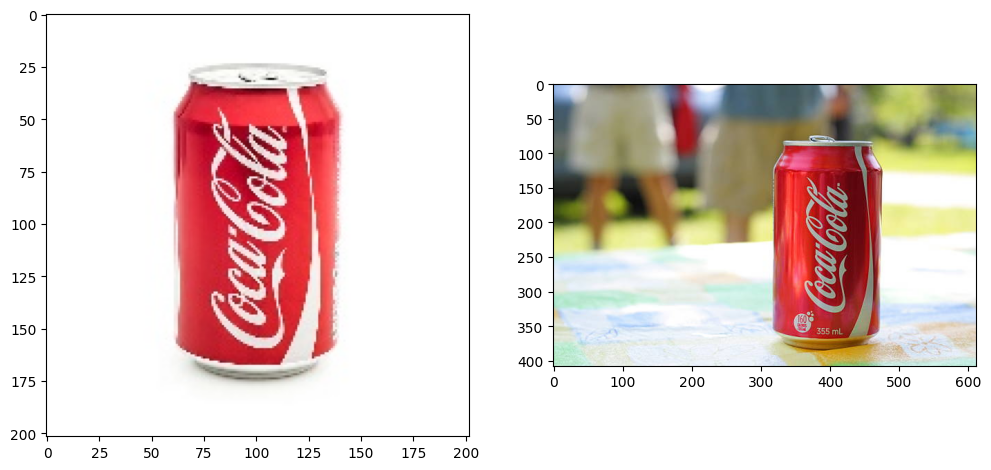

In [11]:
coke = cv2.imread('coke.jpg')[..., ::-1]
table = cv2.imread('coke-table.jpg')[..., ::-1]
f, (a1, a2) = plt.subplots(1, 2, figsize=(12,12))
a1.imshow(coke);
a2.imshow(table);

##### Zadanie 3a

Wykonaj detekcję punktów kluczowych i ich parowanie z użyciem dowolnego matchera. Wykonaj filtrację znalezionych par po dystansie - co obserwujesz, zmieniając próg?

In [12]:
def display_matcher(img1, img2, ct, et, n, d):
    
    sift = cv2.SIFT_create(nfeatures = n, contrastThreshold = ct, edgeThreshold = et)
    kp1, ds1 = sift.detectAndCompute(img1, mask = None)
    kp2, ds2 = sift.detectAndCompute(img2, mask = None)
    d_img1 = cv2.drawKeypoints(img1, kp1, None, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    d_img2 = cv2.drawKeypoints(img2, kp2, None, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(ds1, ds2, k = 2)
    good = []
    for m, n in matches:
        if m.distance < d * n.distance:
            good.append([m])
    matches_img = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    _, axs = plt.subplots(1, 1, figsize = (16, 10))
    axs.imshow(matches_img);
    axs.set_title('Distance constant = {}'.format(d))
    axs.axis('off')
    plt.show()
    
    
def interactive_matcher(img1, img2):
    slider_layout = Layout(width = '40%')
    ct_slider = FloatSlider(value = 0.08, min = 0, max = 1, step = 0.01, description = "contrastThreshold", layout = slider_layout)
    et_slider = FloatSlider(value = 4.2, min = 0, max = 50, step = 0.1, description = "edgeThreshold", layout = slider_layout)
    n_slider = IntSlider(value = 200, min = 0, max = 500, step = 1, description = "nfeatures", layout = slider_layout)
    d_slider = FloatSlider(value = 0.75, min = 0, max = 1, step = 0.01, description = "distance constant", layout = slider_layout)

    interact(display_matcher, img1 = fixed(img1), img2 = fixed(img2), ct = ct_slider, et = et_slider, n = n_slider, d = d_slider)

In [13]:
interactive_matcher(coke, table)

interactive(children=(FloatSlider(value=0.08, description='contrastThreshold', layout=Layout(width='40%'), max…

##### Zadanie 3b

Znajdź transformację geometryczną dla par dopasowanych punktów, tak aby przekształcić `coke` (_train_) do geometrii `table` (_query_). Zademonstruj poprawność, zestawiając obok siebie przekształconą wersję `coke` oraz oryginalny `table`, bądź nanosząc jedno na drugie. Zidentyfikuj punkty, które znaleziona transformacja przekształca "dobrze", tzn. ich współrzędne po przekształceniu leżą w pobliżu odpowiadających im punktów z drugiego obrazu; nanieś je na obraz.

*Jak na wyniki wpływa wykrycie większej lub mniejszej liczby punktów kluczowych na etapie SIFT? W jakim stopniu filtracja poprawia rezultaty? Jak działa i jaką rolę w procesie parowania odgrywa RANSAC?*

In [14]:
from ipywidgets import interact, fixed, Layout, FloatSlider, Dropdown

def object_homography(img1, img2, ct = 0.04, et = 50, d = 0.75, method = cv2.RANSAC, ransac_thresh = 5.0):
    sift = cv2.SIFT_create(nfeatures = 0, contrastThreshold = ct, edgeThreshold = et)
    kp1, ds1 = sift.detectAndCompute(img1, None)
    kp2, ds2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck = False)
    matches = bf.knnMatch(ds1, ds2, k = 2)

    good_matches = []
    for m, n in matches:
        if m.distance < d * n.distance:
            good_matches.append(m)

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    if method == cv2.RANSAC or method == cv2.RHO:
        H, mask = cv2.findHomography(src_pts, dst_pts, method, ransac_thresh)
    else:
        H, mask = cv2.findHomography(src_pts, dst_pts, method)
        
    height, width, _ = img2.shape
    transformed_img = cv2.warpPerspective(img1, H, (width, height))
    
    _, axs = plt.subplots(1, 3, figsize = (15, 5))
    axs[0].imshow(img1);
    axs[0].set_title('Object image')
    axs[0].axis('off')
    axs[1].imshow(transformed_img);
    axs[1].set_title(f'Object transform')
    axs[1].axis('off')
    axs[2].imshow(img2);
    axs[2].set_title('Destination image')
    axs[2].axis('off')
    plt.show()
    
    
def interactive_homography(img1, img2):
    slider_layout = Layout(width = '40%')
    ct_slider = FloatSlider(value = 0.04, min = 0, max = 1, step = 0.01, description = "contrastThreshold", layout = slider_layout)
    et_slider = FloatSlider(value = 50, min = 0, max = 200, step = 0.1, description = "edgeThreshold", layout = slider_layout)
    d_slider = FloatSlider(value = 0.75, min = 0, max = 1, step = 0.01, description = "distance constant", layout = slider_layout)
    method_dropdown = Dropdown(
            options = [('Brak metody', 0), ('RANSAC', cv2.RANSAC), ('RHO', cv2.RHO)],
            value = cv2.RANSAC,
            description = 'Metoda:',
            layout = slider_layout
        )
    
    interact(object_homography, 
             img1 = fixed(img1), 
             img2 = fixed(img2), 
             ct = ct_slider, 
             et = et_slider, 
             d = d_slider, 
             method = method_dropdown)

In [15]:
interactive_homography(coke, table)

interactive(children=(FloatSlider(value=0.04, description='contrastThreshold', layout=Layout(width='40%'), max…